In [2]:
!python -V

Python 3.9.22


In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("01-nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/03-training/experiment_tracking/mlruns/1', creation_time=1747082974574, experiment_id='1', last_update_time=1747082974574, lifecycle_stage='active', name='01-nyc-taxi-experiment', tags={}>

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [8]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.838799799829577

/tmp/ipykernel_2335/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2335/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


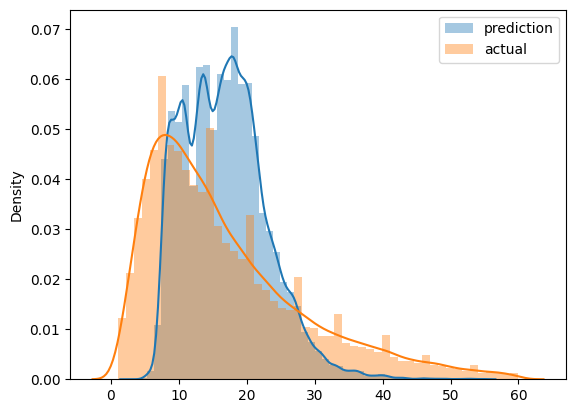

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715209663881

In [18]:
with open('../../models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [26]:
with mlflow.start_run():

    mlflow.set_tag("developer", 'dan r')
    mlflow.log_param("train-data-path", "green_tripdata_2021-01.parquet")
    mlflow.log_param("train-data-path", "green_tripdata_2021-01.parquet")

    alpha = 0.001
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path='./models/lin_reg.bin', artifact_path="models_pickle/")

KeyboardInterrupt: 

In [20]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [21]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [ ]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [25]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:13:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.03974                           
[1]	validation-rmse:7.00533                           
[2]	validation-rmse:6.75823                           
[3]	validation-rmse:6.68099                           
[4]	validation-rmse:6.64511                           
[5]	validation-rmse:6.62575                           
[6]	validation-rmse:6.61523                           
[7]	validation-rmse:6.60865                           
[8]	validation-rmse:6.60424                           
[9]	validation-rmse:6.59861                           
[10]	validation-rmse:6.59471                          
[11]	validation-rmse:6.59329                          
[12]	validation-rmse:6.58905                          
[13]	validation-rmse:6.58659                          
[14]	validation-rmse:6.58521                          
[15]	validation-rmse:6.58028                          
[16]	validation-rmse:6.57700                          
[17]	validation-rmse:6.57573                          
[18]	valid

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:14:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.13707                                                  
[1]	validation-rmse:8.77467                                                   
[2]	validation-rmse:7.90892                                                   
[3]	validation-rmse:7.36920                                                   
[4]	validation-rmse:7.04202                                                   
[5]	validation-rmse:6.84294                                                   
[6]	validation-rmse:6.71803                                                   
[7]	validation-rmse:6.63400                                                   
[8]	validation-rmse:6.57980                                                   
[9]	validation-rmse:6.54138                                                   
[10]	validation-rmse:6.51307                                                  
[11]	validation-rmse:6.49491                                                  
[12]	validation-rmse:6.48164                        

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:16:12] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.71731                                                     
[1]	validation-rmse:6.91056                                                     
[2]	validation-rmse:6.75222                                                     
[3]	validation-rmse:6.70522                                                     
[4]	validation-rmse:6.67698                                                     
[5]	validation-rmse:6.66813                                                     
[6]	validation-rmse:6.66591                                                     
[7]	validation-rmse:6.66385                                                     
[8]	validation-rmse:6.65969                                                     
[9]	validation-rmse:6.65634                                                     
[10]	validation-rmse:6.65600                                                    
[11]	validation-rmse:6.65534                                                    
[12]	validation-rmse:6.65302

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:17:07] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.99692                                                   
[1]	validation-rmse:8.59824                                                   
[2]	validation-rmse:7.74696                                                   
[3]	validation-rmse:7.23961                                                   
[4]	validation-rmse:6.94536                                                   
[5]	validation-rmse:6.77140                                                   
[6]	validation-rmse:6.66549                                                   
[7]	validation-rmse:6.59373                                                   
[8]	validation-rmse:6.55103                                                   
[9]	validation-rmse:6.51878                                                   
[10]	validation-rmse:6.49621                                                  
[11]	validation-rmse:6.47940                                                  
[12]	validation-rmse:6.46694                        

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:18:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.23006                                                       
[1]	validation-rmse:7.81096                                                       
[2]	validation-rmse:7.17111                                                       
[3]	validation-rmse:6.88595                                                       
[4]	validation-rmse:6.74599                                                       
[5]	validation-rmse:6.67495                                                       
[6]	validation-rmse:6.63728                                                       
[7]	validation-rmse:6.61441                                                       
[8]	validation-rmse:6.59990                                                       
[9]	validation-rmse:6.58835                                                       
[10]	validation-rmse:6.57889                                                      
[11]	validation-rmse:6.57476                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:19:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.24026                                                     
[1]	validation-rmse:6.67524                                                     
[2]	validation-rmse:6.59549                                                     
[3]	validation-rmse:6.57159                                                     
[4]	validation-rmse:6.56131                                                     
[5]	validation-rmse:6.54774                                                     
[6]	validation-rmse:6.54285                                                     
[7]	validation-rmse:6.53360                                                     
[8]	validation-rmse:6.52570                                                     
[9]	validation-rmse:6.52028                                                     
[10]	validation-rmse:6.51515                                                    
[11]	validation-rmse:6.50356                                                    
[12]	validation-rmse:6.49985

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:20:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.25265                                                    
[1]	validation-rmse:10.43765                                                    
[2]	validation-rmse:9.75372                                                     
[3]	validation-rmse:9.18066                                                     
[4]	validation-rmse:8.70322                                                     
[5]	validation-rmse:8.30605                                                     
[6]	validation-rmse:7.97988                                                     
[7]	validation-rmse:7.71039                                                     
[8]	validation-rmse:7.48924                                                     
[9]	validation-rmse:7.31094                                                     
[10]	validation-rmse:7.16142                                                    
[11]	validation-rmse:7.04147                                                    
[12]	validation-rmse:6.94269

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:23:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.45135                                                       
[1]	validation-rmse:8.02462                                                       
[2]	validation-rmse:7.32722                                                       
[3]	validation-rmse:6.99445                                                       
[4]	validation-rmse:6.82940                                                       
[5]	validation-rmse:6.74037                                                       
[6]	validation-rmse:6.69322                                                       
[7]	validation-rmse:6.66485                                                       
[8]	validation-rmse:6.64531                                                       
[9]	validation-rmse:6.63318                                                       
[10]	validation-rmse:6.62510                                                      
[11]	validation-rmse:6.61699                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:25:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.22146                                                      
[1]	validation-rmse:10.39138                                                      
[2]	validation-rmse:9.69737                                                       
[3]	validation-rmse:9.12643                                                       
[4]	validation-rmse:8.65878                                                       
[5]	validation-rmse:8.26723                                                       
[6]	validation-rmse:7.95292                                                       
[7]	validation-rmse:7.69932                                                       
[8]	validation-rmse:7.49194                                                       
[9]	validation-rmse:7.32462                                                       
[10]	validation-rmse:7.18764                                                      
[11]	validation-rmse:7.07895                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:29:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.90504                                                      
[1]	validation-rmse:9.88281                                                       
[2]	validation-rmse:9.09266                                                       
[3]	validation-rmse:8.48908                                                       
[4]	validation-rmse:8.03308                                                       
[5]	validation-rmse:7.69067                                                       
[6]	validation-rmse:7.43517                                                       
[7]	validation-rmse:7.24350                                                       
[8]	validation-rmse:7.10186                                                       
[9]	validation-rmse:6.99336                                                       
[10]	validation-rmse:6.91227                                                      
[11]	validation-rmse:6.85058                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:31:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.62465                                                       
[1]	validation-rmse:9.45611                                                        
[2]	validation-rmse:8.61027                                                        
[3]	validation-rmse:8.00960                                                        
[4]	validation-rmse:7.58807                                                        
[5]	validation-rmse:7.29566                                                        
[6]	validation-rmse:7.08876                                                        
[7]	validation-rmse:6.94306                                                        
[8]	validation-rmse:6.84114                                                        
[9]	validation-rmse:6.76957                                                        
[10]	validation-rmse:6.71449                                                       
[11]	validation-rmse:6.67483                                                

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [22:34:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.12359                                                       
[1]	validation-rmse:8.78797                                                        
[2]	validation-rmse:7.96027                                                        
[3]	validation-rmse:7.46040                                                        
[4]	validation-rmse:7.16561                                                        
[5]	validation-rmse:6.98884                                                        
[6]	validation-rmse:6.88095                                                        
[7]	validation-rmse:6.81400                                                        
[8]	validation-rmse:6.77156                                                        
[9]	validation-rmse:6.74350                                                        
[10]	validation-rmse:6.72354                                                       
[11]	validation-rmse:6.70783                                                

KeyboardInterrupt: 